In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Deep Neural Network (DNN)


![dnn](http://ufldl.stanford.edu/tutorial/images/Network3322.png)


* **neuron** is a unit that takes input vector and outputs a single value.
* **layer** is a set of neurons with the same input vector.
* **NN** is a set of layers that are serially connected.

## Neuron
![neuron](https://www.dropbox.com/s/b6juegvqmaul9zm/Neuron.png?dl=0&raw=1)
* A neuron defines a hyperplane and computes the distance from the hyperplane
* The distance is non-linearly transformed.

## Layer
* just a **linear (affine) map + coordinate-wise non-linear transform**
![nonlinear](https://upload.wikimedia.org/wikipedia/en/thumb/9/96/Jacobian_determinant_and_distortion.svg/1280px-Jacobian_determinant_and_distortion.svg.png)

## Implementation

Now let's implement NN in `tensorflow`!

### Layer
$$ h = \sigma (xw + b)$$
where
$ x \in \mathbb{R}^{n \times d}$,
$ w \in \mathbb{R}^{d \times h}$,
$ b \in \mathbb{R}^{h}$,
$ h \in \mathbb{R}^{n \times h}$ 
and $\sigma(\cdot)$ is a non-linear activation function.

Let us define the tensors.

In [2]:
tf.reset_default_graph()

x = tf.placeholder('float32', name='x')

initial_w = tf.truncated_normal(
                shape=(784, 50),
                mean=0.0, stddev=0.05 )
w = tf.Variable(initial_w, name='w')
b = tf.Variable(tf.zeros(shape=(50,)), name='b')

p = tf.matmul(x, w) + b
h = tf.sigmoid(p)

In [3]:
print x
print w
print b
print p
print h

Tensor("x:0", dtype=float32)
Tensor("w/read:0", shape=(784, 50), dtype=float32)
Tensor("b/read:0", shape=(50,), dtype=float32)
Tensor("add:0", shape=(?, 50), dtype=float32)
Tensor("Sigmoid:0", shape=(?, 50), dtype=float32)


Now, let's evaluate

In [4]:
try:
    sess.close()
except NameError:
    pass
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Load values on GPU
init = tf.global_variables_initializer() 
sess.run(init) 

print "w: \n", sess.run(w)
print "b: \n", sess.run(b)
# print sess.run(p)  # Error. Cause we did not fed the `x`
print "p shape: \n", sess.run(tf.shape(p), feed_dict={x: np.zeros(shape=(10,784))})

w: 
[[-0.01978522 -0.03701908  0.00173414 ..., -0.03695784 -0.00404362
  -0.04204103]
 [-0.01156722 -0.02122275 -0.00015096 ..., -0.01285659  0.02257659
   0.04365627]
 [-0.03592727 -0.06887783 -0.02188897 ..., -0.04344362 -0.00019892
  -0.05169927]
 ..., 
 [-0.07695314  0.05556419  0.00865975 ..., -0.01810805  0.02756076
  -0.07012396]
 [-0.04961478 -0.04401775 -0.03598289 ..., -0.00596834 -0.06027857
  -0.028662  ]
 [-0.05322649 -0.04775993 -0.08076386 ..., -0.06489704 -0.04416345
  -0.03478109]]
b: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
p shape: 
[10 50]


### Set of Layers
To stack the layers, let us generalize a little bit the above.

In [5]:
layer_spec = [784, 100, 30, 10]
n_layer = len(layer_spec)-1
print "num of layers: ", n_layer

num of layers:  3


Note that the final layer of NN is logistic regression.

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, name='x')

inp = x
hs = []
for l in xrange(n_layer):
    with tf.name_scope('p{}'.format(l)):

        initial_w = tf.truncated_normal(
                shape=(layer_spec[l], layer_spec[l+1]),
                mean=0.0, stddev=0.05)
        w = tf.Variable(initial_w, name='w')
        b = tf.Variable(tf.zeros((layer_spec[l+1],)), name='b')
        p = tf.matmul(inp,w) + b

    with tf.name_scope('h{}'.format(l)):

        if l == n_layer-1: # Last layer
            h = p
        else: 
            h = tf.nn.relu(p)
        hs.append(h)
        inp = h

In [7]:
try:
    sess.close()
except NameError:
    pass
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Load values on GPU
init = tf.global_variables_initializer() 
sess.run(init) 

print "h shape: \n", sess.run(tf.shape(hs[-1]), feed_dict={x: np.zeros(shape=(30,784))})

h shape: 
[30 10]


### Loss
We define the loss as the **negative log-likelihood**, or the **cross-entropy**.
$$\sum_i \sum_k -\mathcal{I}(t_i=k) \log P(y_i=k|x_i;\theta)$$

In [8]:
t = tf.placeholder('int32', name='t')
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            hs[-1], t, name='xent')

loss = tf.reduce_mean(xent, name='loss')
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
tf.summary.scalar('loss', loss)

pred = tf.argmax(hs[-1], axis=1)
tf.summary.histogram('predicted_label', pred)

correct = tf.nn.in_top_k(hs[-1], t, 1)
acc = tf.reduce_mean(tf.cast(correct, tf.float32))
tf.summary.scalar('acc', acc)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("nn_train_log", sess.graph)

### Load Data
We use MNIST hand-written digit recognition data.
* Total 70k images
* 784 dimension (28x28 pixels, gray-scale) 
* Train, Test, Validation Sets are divided a priori.

The objective is to classify each image as one of 10 classes (0-9).

['train_t', 'train_x', 'valid_x', 'test_t', 'valid_t', 'test_x']
(50000, 784)
class:  5


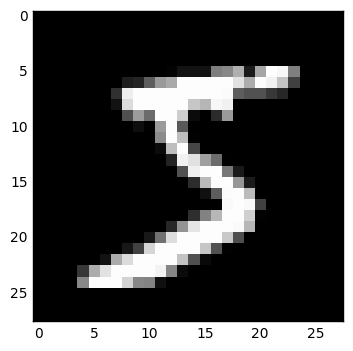

In [9]:
mnist = np.load('data/mnist.npz')
print mnist.keys()
print mnist['train_x'].shape

train_x = mnist['train_x']
train_t = mnist['train_t']

plt.imshow(train_x[0].reshape((28, 28)), 
               interpolation='nearest', cmap=plt.get_cmap('gray'))
print "class: ", train_t[0]

### Stochastic Gradient Descent
Loss:
$$ \mathcal{L}(X; \theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L(x_i; \theta)}$$
Gradient Descent:
$$ \theta^{t+1} = \theta^{t} - \eta \frac{1}{n}\sum_{i=1}^n \frac{\partial \mathcal{L}(X_i;\theta)}{\partial \theta} \vert _{\theta=\theta^t} $$

Stochastic Gradient Descent:

---
**for** $k=1$ **to** $n/m$:
$$ \theta^{k+1} = \theta^{k} - \eta \frac{1}{k}\sum_{i=1}^m \frac{\partial \mathcal{L}(X_i;\theta)}{\partial \theta} \vert _{\theta=\theta^k} $$
**end**

$\theta^{t+1}=\theta^{k=n/m}$

---
**Principle**:

*Instead of computing the exact gradient direction using the full batch data and update once, compute a **noisy gradient** direction using partial (mini-batch) data and update **multiple times**.*

Epoch: 0, Loss: 2.29812550545, Acc: 0.168459996581
Epoch: 1, Loss: 2.28464698792, Acc: 0.289559990168
Epoch: 2, Loss: 2.24721717834, Acc: 0.388280004263
Epoch: 3, Loss: 2.10425901413, Acc: 0.435359984636
Epoch: 4, Loss: 1.66656410694, Acc: 0.512579977512
Epoch: 5, Loss: 1.13887917995, Acc: 0.685580015182
Epoch: 6, Loss: 0.844299733639, Acc: 0.762440025806
Epoch: 7, Loss: 0.689577281475, Acc: 0.805400013924
Epoch: 8, Loss: 0.593821525574, Acc: 0.831380009651
Epoch: 9, Loss: 0.532407462597, Acc: 0.849179923534
Epoch: 10, Loss: 0.491501033306, Acc: 0.86062002182
Epoch: 11, Loss: 0.462415188551, Acc: 0.868619978428
Epoch: 12, Loss: 0.44043046236, Acc: 0.874579966068
Epoch: 13, Loss: 0.422934681177, Acc: 0.879899978638
Epoch: 14, Loss: 0.408390074968, Acc: 0.884559988976
Epoch: 15, Loss: 0.395857155323, Acc: 0.888119995594
Epoch: 16, Loss: 0.384767442942, Acc: 0.891559958458
Epoch: 17, Loss: 0.374747306108, Acc: 0.894719958305
Epoch: 18, Loss: 0.365587562323, Acc: 0.897379994392
Epoch: 19, 

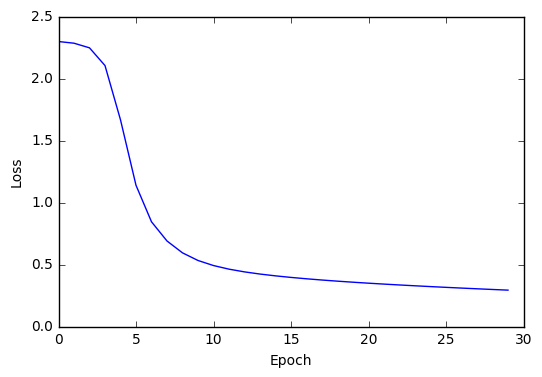

In [10]:

num_train = train_x.shape[0]
mb_size = 200
num_mbs = int(num_train / mb_size)

loss_history = []
for epoch in xrange(30):
    loss_vals = []
    acc_vals = []
    for mb in xrange(num_mbs):
        data_x = train_x[mb*mb_size : (mb+1)*mb_size] 
        data_t = train_t[mb*mb_size : (mb+1)*mb_size] 

        _, loss_val, acc_val, summary = sess.run([train_step, loss, acc, merged_summary], 
                                            feed_dict={x: data_x, t: data_t})
        loss_vals.append(loss_val)
        acc_vals.append(acc_val)
        writer.add_summary(summary, epoch*num_mbs+mb)
    print "Epoch: {}, Loss: {}, Acc: {}".format(
        epoch, np.mean(loss_vals), np.mean(acc_vals) )

    loss_history.append(np.mean(loss_vals))

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [11]:
test_x = mnist['test_x']
test_t = mnist['test_t']
test_mb_size = 200
test_num_mbs = test_x.shape[0] / test_mb_size

test_accs = []
for mb in xrange(test_num_mbs):
    test_acc = sess.run(acc, feed_dict={
        x: test_x[mb*test_mb_size : (mb+1)*test_mb_size],
        t: test_t[mb*test_mb_size : (mb+1)*test_mb_size]})
    test_accs.append(test_acc)
print "test acc: ", np.mean(test_accs)

test acc:  0.9203


Populating the interactive namespace from numpy and matplotlib


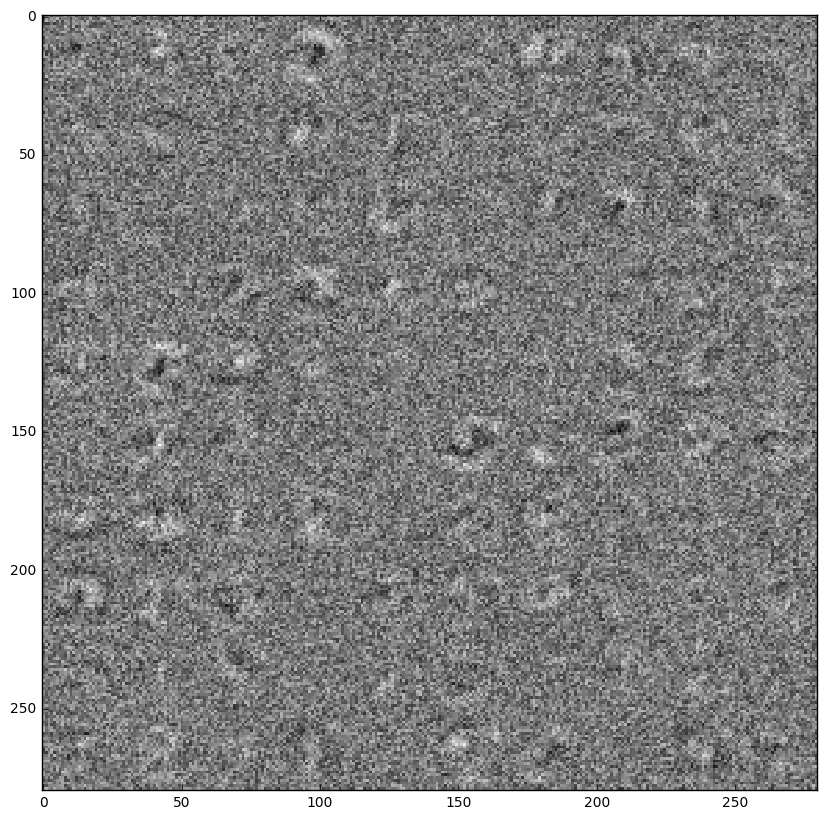

In [13]:
import matplotlib.pyplot as plt
%pylab inline
size_h = 28
size_w = 28
def viz_tile_images(imgs, n_col=10, normalize=True):
    num = imgs.shape[0]
    n_row = int((num-1)/n_col)+1
    total_img = np.zeros((n_row*size_h, n_col*size_w))
    for r in xrange(n_row):
        for c in xrange(n_col):
            idx = r*n_col+c
            if idx < num:
                img = np.reshape(imgs[idx], (size_w, size_h))
                if normalize:
                    img = (img - np.min(img))/(np.max(img) - np.min(img))
                total_img[r*size_h:(r+1)*size_h, c*size_w:(c+1)*size_w] = img
    
    orig_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (n_col,n_row)
    plt.imshow(total_img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    plt.rcParams['figure.figsize'] = orig_fig_size
    

    
w = sess.run([v for v in tf.global_variables() if v.name == "p0/w:0"][0])
viz_tile_images(w.T, normalize=False)